In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_auc_score, precision_score

##Rede neural para Regressão

Material baseado no script do prof. Rafael Scopel

Importando base de dados do dataset California Districts.

A variável alvo é a mediana do preço de casas em distritos da California, expresso em milhares de dólares ($100,000).

Descrição das features:
- MedInc        median income in block group
- HouseAge      median house age in block group
- AveRooms      average number of rooms per household
- AveBedrms     average number of bedrooms per household
- Population    block group population
- AveOccup      average number of household members
- Latitude      block group latitude
- Longitude     block group longitude


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

temp = fetch_california_housing()

features = temp.feature_names
target = "HouseValue"


df_data = pd.DataFrame(temp.data, columns=[features])

df_data['HouseValue'] = temp.target

df_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Vamos entender melhor nossos dados vendo algumas estatísticas básicas fornecidas pela biblioteca pandas e analisando histogramas.

In [3]:
df_data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Vamos plottar os histogramas dos nossos dados.

array([[<Axes: title={'center': "('MedInc',)"}>,
        <Axes: title={'center': "('HouseAge',)"}>,
        <Axes: title={'center': "('AveRooms',)"}>],
       [<Axes: title={'center': "('AveBedrms',)"}>,
        <Axes: title={'center': "('Population',)"}>,
        <Axes: title={'center': "('AveOccup',)"}>],
       [<Axes: title={'center': "('Latitude',)"}>,
        <Axes: title={'center': "('Longitude',)"}>,
        <Axes: title={'center': "('HouseValue',)"}>]], dtype=object)

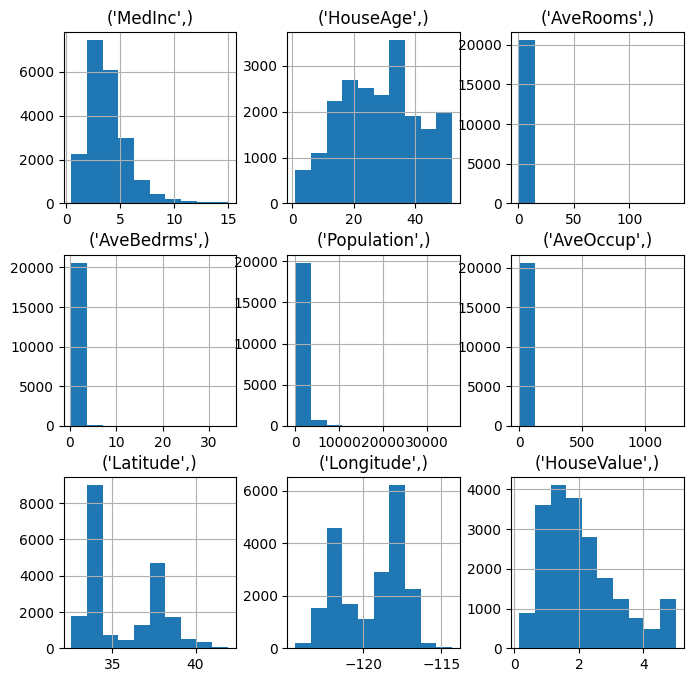

In [4]:
df_data.hist(figsize=(8,8),layout=(3,3))

Nosso objetivo será usar o MLP (multilayer perceptron, ou simplesmente rede neural) para prever o preço de uma casa ("HouseValue") com base nos seus atributos.

Vamos separar a amostra de treino e teste em 70% - 30%.

In [5]:
df_train, df_test = train_test_split(df_data,test_size=0.3, random_state=24)

X_train_full = df_train[features].values.reshape(-1,np.size(features))
X_test = df_test[features].values.reshape(-1,np.size(features))
y_train_full = df_train[target].values.reshape(-1,1)
y_test = df_test[target].values.reshape(-1,1)

Normalizamos os atributos X.

In [6]:
scaler = StandardScaler()

X_train_full_scaled = scaler.fit(X_train_full).transform(X_train_full)
X_test_full_scaled = scaler.fit(X_train_full).transform(X_test)

In [7]:
pd.DataFrame(X_train_full_scaled)

,0,1,2,3,4,5,6,7
0,3.248316,-0.526757,0.988357,-0.095622,1.209354,-0.010720,-0.873051,0.580126
1,0.564645,-2.036163,0.738304,0.125251,12.986196,-0.004315,1.314347,-0.937675
2,0.695141,-1.480066,-0.149263,0.050918,0.154438,-0.073643,0.765151,-1.193146
3,-0.008033,-0.208987,-0.168477,-0.360858,-0.241701,0.048335,-1.417554,1.261383
4,1.439554,-1.162296,0.649334,-0.193806,1.461521,-0.003362,-1.196937,1.161198
...,...,...,...,...,...,...,...,...
14443,-0.796260,1.856515,-1.186881,-0.612699,-1.006057,0.042216,-0.732232,0.765468
14444,-1.162216,-0.685642,0.093782,0.146793,-0.341172,0.075946,0.337998,0.074192
14445,-0.032987,-1.797835,-0.487026,-0.152198,0.103830,-0.085584,-1.272040,1.216300
14446,0.439560,-0.050102,-0.185051,-0.066825,-0.068063,-0.018454,0.896582,-1.203165


Adicionalmente, vamos criar uma partição de validação para definir o critério de convergência do nosso modelo.

A amostra de validação será 10% da amostra de treino total.

In [8]:
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(X_train_full_scaled, y_train_full,test_size=0.1, random_state=24)

Carregar as bibliotecas de Keras e TensorFlow para construção do nosso MLP.

In [15]:
import tensorflow as tf
from tensorflow import keras 

print(tf.__version__)

2.13.0


Limpando o ambiente Keras e setando as seeds dos geradores aleatórios para replicação dos resultados.

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Vamos construir um MLP com 4 Camadas:

1.   Camada de entrada com 8 entradas + 1 viés
2.   Camada interna 1 com 50 neurônios, função de ativação RELU
3.   Camada interna 2 com 20 neurônios, função de ativação RELU
4.   Camada de saída com 1 neurônio e sem função de ativação








In [11]:
m,n = X_train_scaled.shape
n

8

In [12]:
model = keras.models.Sequential([                       #cria um modelo que é uma sequência de camadas
        keras.layers.InputLayer(input_shape=n),         #camada de entrada, teremos n = número de features entradas
        keras.layers.Dense(50, activation="relu"),      #primeira hidden layer, totalmente conectada com 50 neurônios e função de ativação ReLU.
        keras.layers.Dense(20, activation="relu"),      #segunda hidden layer, 20 neurônios.
        keras.layers.Dense(1)                           #camada de saíde, 1 neurônio de ativação linear para realizar a regressão.
    ])

Temos um MLP com 1.491 parâmetros para treino:

- 8 features do nosso dataset + bias = 9
- 9 * 50 neurônios da primeira camada = 450 parâmetros na primeira camada.
- 50 saídas dos neurônios da primeira camada * 20 neurônios na segunda camada + 20 biases = 1020
- 20 saídas da segunda camada * 1 neurônio de saída + 1 bias = 21

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Vamos gerar um diagrama pra visualizar nossa rede.

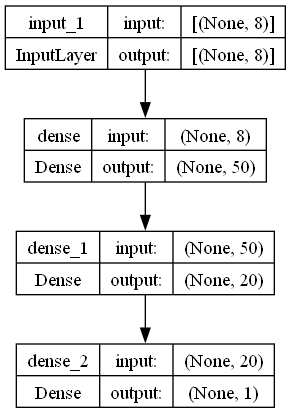

In [14]:
keras.utils.plot_model(model, show_shapes=True)

Compilamos o modelo e utilizamos como função de perda o MSE e o algoritmo de backpropagation para estimar os coeficientes.

In [17]:
model.compile(loss="mean_squared_error", optimizer="sgd")

Estimar o modelo com 50 épocas.

Para cada época, serão calculados a loss para o conjunto de treinamento e a loss para o conjunto de validação.

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid))               


Epoch 1/50
407/407 [==============================] - 1s 2ms/step - loss: 0.7750 - val_loss: 0.4876
Epoch 2/50
407/407 [==============================] - 1s 1ms/step - loss: 0.4903 - val_loss: 0.4360
Epoch 3/50
407/407 [==============================] - 1s 1ms/step - loss: 0.4574 - val_loss: 0.7223
Epoch 4/50
407/407 [==============================] - 1s 1ms/step - loss: 0.4494 - val_loss: 0.4711
Epoch 5/50
407/407 [==============================] - 1s 1ms/step - loss: 0.4235 - val_loss: 0.3969
Epoch 6/50
407/407 [==============================] - 1s 1ms/step - loss: 0.4161 - val_loss: 0.3849
Epoch 7/50
407/407 [==============================] - 0s 1ms/step - loss: 0.3938 - val_loss: 0.3711
Epoch 8/50
407/407 [==============================] - 0s 1ms/step - loss: 0.3810 - val_loss: 0.3633
Epoch 9/50
407/407 [==============================] - 0s 1ms/step - loss: 0.3725 - val_loss: 0.3598
Epoch 10/50
407/407 [==============================] - 0s 1ms/step - loss: 0.3676 - val_loss: 0.3607

Vamos plottar as curvas de aprendizado.

Cada curva é o valor de loss em cada época de treinamento.

Com isto, podemos investigar se nosso modelo está aprendendo bem tanto para o conjunto de treinamento quanto para o conjunto de validação, ou se está sofrendo de overfitting e tem resultados bons apenas no conjunto de treinamento.

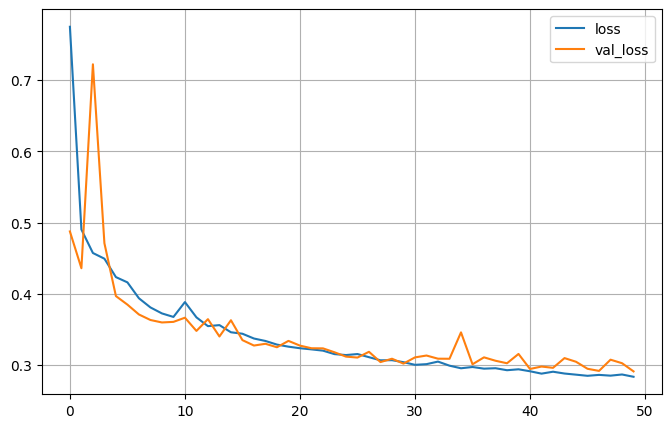

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

Agora vamos calcular a média do erro quadrado com o modelo já treinado no conjunto de treino e de teste.


**CONJUNTO DE TESTE NÃO É CONJUNTO DE VALIDAÇÃO!!**

In [20]:
print("MSE Treino: ", model.evaluate(X_train_scaled, y_train))
print("MSE Teste: ", model.evaluate(X_test_full_scaled, y_test))

407/407 [==============================] - 0s 1ms/step - loss: 0.2790
MSE Treino:  0.27904900908470154
194/194 [==============================] - 0s 1ms/step - loss: 0.2982
MSE Teste:  0.298238068819046


Vamos predizer o conjunto de teste para termos uma ideia de como o modelo se comporta.

Como normalizamos o conjunto de treinamento, é crucial que as instâncias usadas na predição também sejam normalizadas com a mesma distribuição.

In [21]:
preds = model.predict(X_test_full_scaled)

194/194 [==============================] - 0s 829us/step


Para visualizar as predições, podemos reverter a normalização utilizada nas features de entrada para verificar os valores originais de cada feature (a variável alvo nunca é normalizada!)

Vamos colocar as predições do modelo ao lado dos valores já conhecidos de y para o conjunto de teste, para uma comparação visual simples.

In [22]:

test_features = scaler.inverse_transform(X_test_full_scaled)

df_predict = pd.DataFrame(test_features, columns=[features]) #features contém os headers originais do dataset

df_predict['HouseValue predicted'] = preds
df_predict['HouseValue known'] = y_test

df_predict.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HouseValue predicted,HouseValue known
0,5.7613,23.0,6.296748,1.101626,1486.0,3.020325,34.20,-118.62,2.964334,2.358
1,4.1500,11.0,5.500933,1.061567,2728.0,2.544776,35.62,-117.66,1.134640,0.857
2,7.1497,21.0,6.755245,0.930070,860.0,3.006993,33.61,-117.66,2.866007,2.740
3,3.4312,52.0,6.359909,1.050114,1177.0,2.681093,33.99,-118.03,2.175018,2.438
4,1.5026,10.0,3.326642,1.076642,2176.0,3.970803,33.75,-117.88,1.449029,1.518
5,4.9091,9.0,5.243243,1.137214,1591.0,3.307692,37.39,-121.87,2.146353,2.597
6,3.6797,20.0,5.348018,1.041850,1145.0,2.522026,36.97,-122.05,2.692495,2.638
7,4.3750,15.0,5.373626,1.027473,407.0,2.236264,34.86,-120.41,2.149895,1.580
8,2.5833,35.0,4.472906,1.113300,667.0,3.285714,34.10,-117.46,1.115220,0.935
9,4.2564,25.0,5.592105,1.085526,4528.0,4.255639,33.79,-117.81,1.860639,2.046


Salvar o modelo.

In [23]:
model.save("/content/drive/MyDrive/Data/Meu_MLP")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Meu_MLP\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Meu_MLP\assets


Carregar o modelo

In [24]:
model = 0

model = keras.models.load_model("/content/drive/MyDrive/Data/Meu_MLP")

## MLP para Classificação

Importando base de dados composta por imagens itens de moda pertencentes a 10 classes. Cada imagem é composta 28x28 pixels em grayscale (valores entre 0-255).

A base já virá dividida entre treino e teste. 



*   60000 instâncias de treino
*   10000 instâncias de teste



In [57]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [61]:
print(X_train_full.shape)

(60000, 28, 28)


In [60]:
print(X_train_full.dtype)

uint8


Normalizamos os atributos X, para assumirem um valor entre 0 e 1. Faremos isto dividindo por 255 (valores possíveis para uma representação de imagem em grayscale).

Adicionalmente, criamos uma particição de validação. Agora teremos:


*   55.000 itens de treino
*   5.000 itens de validação



In [66]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Shape de um exemplo de treinamento é o tamanho da imagem.

In [67]:
print(X_train[1].shape)

(28, 28)


Como a imagem é representada no array normalizado.

In [68]:
print(X_train[1])

[[0.         0.         0.         0.         0.         0.
  0.         0.17254902 0.21568627 0.37647059 0.78823529 0.1372549
  0.         0.         0.         0.         0.         0.23529412
  0.72156863 0.20784314 0.19607843 0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.35686275 0.40784314 0.3254902  0.17254902 0.70196078 0.95294118
  0.83921569 0.61176471 0.58039216 0.83137255 0.97254902 1.
  0.72156863 0.15686275 0.3372549  0.42745098 0.30588235 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.29411765
  0.55686275 0.19607843 0.29411765 0.23529412 0.08235294 0.38431373
  0.83137255 0.8745098  0.73333333 0.90980392 0.83137255 0.36862745
  0.01568627 0.22352941 0.25490196 0.21568627 0.56078431 0.27843137
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.41960784
  0.52941176 0.3

Vamos criar uma lista com o nome das classes para facilitar a compreensão. Lembrando que são 10 classes diferentes.

In [69]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [74]:
print(class_names[y_train[0]])

Coat


Visualizando um exemplo como imagem.

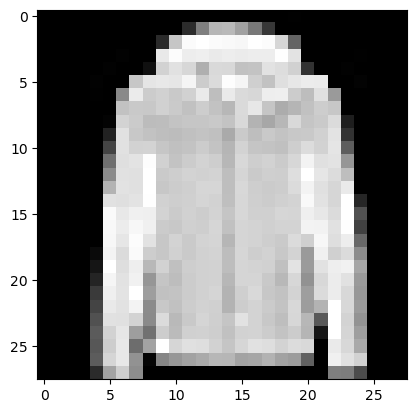

In [72]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))

Vamos visualizar alguns outros exemplos para ter ideia de como é o dataset.

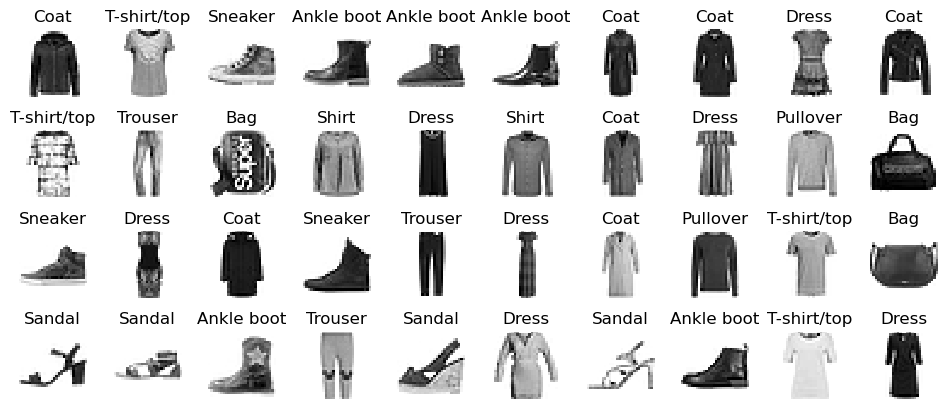

In [53]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))  
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Vamos construir um MLP com 4 Camadas:

1.   Camada de entrada com que irá receber as imagens em matrizes 28x28 e irá converter em um vetor de uma dimensão de 784 entradas, uma para cada pixel.
2.   Camada escondida 1 com 300 neurônios, função de ativação ReLU.
3.   Camada escondida 2 com 100 neurônios, função de ativação ReLU.
4.   Camada de saída com 10 neurônios e função de ativação SOFTMAX para classificação multiclasse.








In [84]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"), #784 entradas * 300 neurônios = 235200 parâmetros para serem ajustados. Considerando os biases serão 235500 ao total.
        keras.layers.Dense(100, activation="relu"), #300 saídas da camada anterior * 100 neurônios = 30000 parâmetros. Considerando biases o total será de 30100.
        keras.layers.Dense(10, activation="softmax") #100 saídas da camada anterior * 10 neurônios da camada = 1000. Considerando biases o total será de 1010.
])

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Plotando um diagrama da nossa rede.

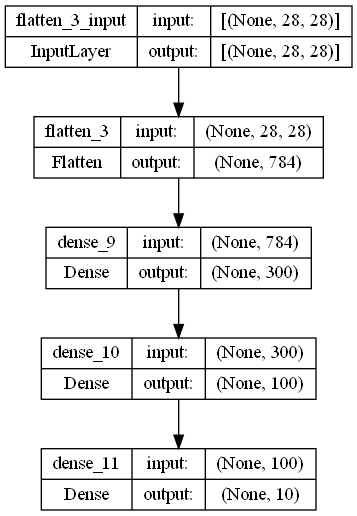

In [85]:
keras.utils.plot_model(model, show_shapes=True)

Compilar o modelo. Usando como função de perda a entropia cruzada, otimizador "Gradiente Descendente Estocástico" e métrica acurácia.

In [88]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Estimar o modelo com 30 épocas.

In [89]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))             

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7290 - accuracy: 0.7578 - val_loss: 0.5241 - val_accuracy: 0.8180
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4884 - accuracy: 0.8287 - val_loss: 0.4366 - val_accuracy: 0.8508
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4428 - accuracy: 0.8432 - val_loss: 0.5537 - val_accuracy: 0.7948
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4156 - accuracy: 0.8545 - val_loss: 0.3964 - val_accuracy: 0.8678
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3969 - accuracy: 0.8609 - val_loss: 0.3808 - val_accuracy: 0.8666
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3782 - accuracy: 0.8661 - val_loss: 0.3830 - val_accuracy: 0.8704
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3661 - accuracy: 0.8718 - val_loss: 0.3679 - val_accuracy:

Plotando a função de perda e acurácia do modelo para treino e validação.

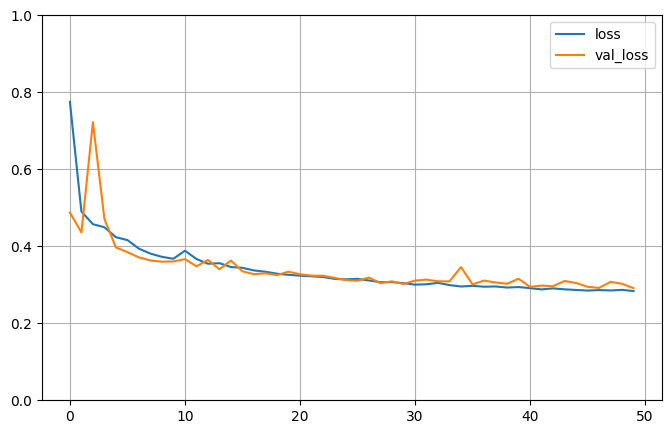

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.grid(True)

Acurácia de Treino e Teste.

In [91]:
print("Loss e Acurácia Treino: ", model.evaluate(X_train, y_train))
print("Loss e Acurácia Teste: ", model.evaluate(X_test, y_test))

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2275 - accuracy: 0.9173
Loss e Acurácia Treino:  [0.2275022268295288, 0.9173454642295837]
313/313 [==============================] - 1s 2ms/step - loss: 76.4433 - accuracy: 0.8286
Loss e Acurácia Teste:  [76.44332122802734, 0.8285999894142151]


Classificando uma instância nova

In [99]:
X_new = X_test[:1]

y_proba = model.predict(X_new)
y_proba.round(4) #arredonda para no máximo 4 casas decimais
y_proba

1/1 [==============================] - 0s 20ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Nome da classe predita.

In [100]:
print(class_names[np.argmax(y_proba)])

Ankle boot


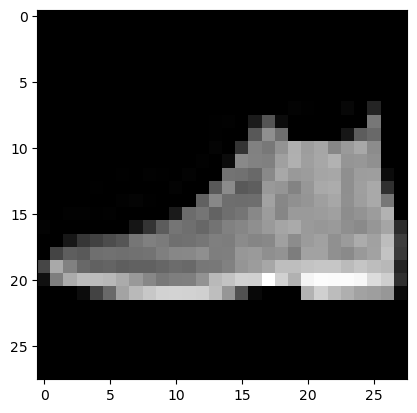

In [101]:
plt.imshow(X_new[0], cmap=plt.get_cmap('gray'))

Salvando o modelo.

In [ ]:
model.save("/content/drive/MyDrive/Data/Meu_MLP_clas")

Carregando o modelo.

In [ ]:
model = 0

model = keras.models.load_model("/content/drive/MyDrive/Data/Meu_MLP_clas")